### Choix d'un modèle dynamique
Pour simuler le débordement sur le bassin Gambie, nous avons choisi d'utiliser un **modèle dynamique PCRaster** basé sur la classe `DynamicModel`.
#### Pourquoi un modèle dynamique?
- **Evolution temporelle** : Les phénomènes hydrologiques(écoulement, inondation, ruissellement) sont dépendants du temps. Le modèle dynamique permet d'intégrer cette évolution pas à pas.
- **Simulation réaliste** : Il permet d'observer l'impact cumulé des précipitation, de la topographie, de l'occupation du sol, etc sur la propagation de l'eau.
- **Flexibilité** : Grâce aux itérations temporelles, il est possible d'intégrer des paramètres variables dans le temps(ex. précipitations journalières, gestion des barrages, etc.).
Ce modèle est donc adapté pour reproduire et analyser le comportement spatial et  temporel des inondations dans le bassin.

### Séparation des traitement statiques et dynamiques
Dans un souci de performation et de modularité, certains traitements geospataux lourds ou invariant ont été externalisés de la classe `DynamicModel`. L'objectif est de les exécuter une seule fois en amont, puis sauvegarder les résultats pour les réutilisés dans la simulation dynamiques

### Traitements préalables effectués hors de `DynamicModel`

#### Importation des bibliothèques python

In [2]:
import pcraster as pcr
import numpy as np
import glob
import os
%matplotlib inline
import matplotlib.pyplot as plt
from osgeo import gdal, osr, gdalconst
from pyproj import Transformer
from pcraster.framework import DynamicModel, DynamicFramework
import math
gdal.UseExceptions()

#### Lecture du MNT et affichage des ses proprietés

In [2]:
# Fonction pour l'affichage des proprietés des datasets
def gdal_properties(input_path): # Affichier les proprietés pour chaque fichier
    if not os.path.exists(input_path):
        raise ValueError(f"Fichier introuvable")
    raster = gdal.Open(input_path)
    path = raster.GetDescription()
    width = raster.RasterXSize
    height = raster.RasterYSize
    projection = raster.GetProjection()
    geotransform = raster.GetGeoTransform()
    metadata = raster.GetMetadata()
    numband = raster.RasterCount # chacune de nos rasters ne renferme qu'une bande
    
    band = raster.GetRasterBand(1)
    data_type = band.DataType
    data_type_name = gdal.GetDataTypeName(data_type)
    print(f"Le type de données de la bande 1: {data_type_name}")
    driver = raster.GetDriver().ShortName
    print("#############################################")
    print('Propriétés')
    print(f"{path} a {width} x {height} comme dimension")
    print(f"Driver: {driver}")
    print(f"Nombre de bande: {numband}")
    print(f"Les metadonnées: {metadata}")

    srs = osr.SpatialReference() 
    srs.ImportFromWkt(projection)
    epsg_code = srs.GetAuthorityCode(None)
    unit_name = "Degree" if epsg_code == "4326" else srs.GetLinearUnitsName()
    unit_value = srs.GetLinearUnits()
    print(f"Unité de la projection: {unit_name} {unit_value}")

    if geotransform:
        
        print(f"Origine: ({geotransform[0]}, {geotransform[3]})")
        print(f"Size: ({geotransform[1]} {unit_name}, {geotransform[5]} {unit_name})")
    layerBand = raster.GetRasterBand(1)
    min_value, max_value = layerBand.ComputeRasterMinMax()
    print(f"Valeur minimale {min_value}")
    print(f"Valeur maximale {max_value}")
    print("#############################################")
    raster = None

In [3]:
basin_raster_paths = glob.glob('Data/basin*.tif') # Charger les fichiers geotiff
for path in basin_raster_paths:
    
    gdal_properties(path)
    print('\n')

Le type de données de la bande 1: Int16
#############################################
Propriétés
Data\basin_dem.tif a 18137 x 12359 comme dimension
Driver: GTiff
Nombre de bande: 1
Les metadonnées: {'AREA_OR_POINT': 'Area'}
Unité de la projection: Degree 1.0
Origine: (-16.15022041715082, 14.68830289986267)
Size: (0.0002694945852358564 Degree, -0.0002694945852358564 Degree)
Valeur minimale -29.0
Valeur maximale 1530.0
#############################################




#### Alignement du MNT
Pour une cohérence spatiales, on va aligner le MNT sur la grille, avec:
- une projection (EPSG:32628 - UTM Zone 28N)
- Une résolution fixe (100m). Le choix de cette résolution repose sur un compromis entre la capacité de traitement disponible et une précision géographique. Une résolution fine (30m, 10m) offrirait plus de détails mais générerait des rasters de grande taille difficillement manipulables dans une environnement contraint comme mon ordinateur personnel avec une RAM un processeur limités.


In [4]:
def reproject_raster_get_origin(input_raster, target_epsg=32628, resolution=100):
    output_raster = "Data/Aligned_rasters/mnt_utm.tif"
    warp_options = gdal.WarpOptions(
        dstSRS=f"EPSG:{target_epsg}",
        xRes=resolution,
        yRes=resolution,
        resampleAlg='near'
    )
    gdal.Warp(output_raster, input_raster, options=warp_options)


In [5]:
# Reprojection du MNT et extraction des métadonnées
mnt_path = 'Data/basin_dem.tif'
reproject_raster_get_origin(mnt_path)

#### Verification de la reprojection du MNT

In [6]:
aligned_raster_paths = glob.glob('Data/Aligned_rasters/*.tif')
for path in aligned_raster_paths:
    
    gdal_properties(path)
    print('\n')

Le type de données de la bande 1: Int16
#############################################
Propriétés
Data/Aligned_rasters\mnt_utm.tif a 5336 x 3717 comme dimension
Driver: GTiff
Nombre de bande: 1
Les metadonnées: {'AREA_OR_POINT': 'Area'}
Unité de la projection: metre 1.0
Origine: (374491.5725851272, 1627184.8412821454)
Size: (100.0 metre, -100.0 metre)
Valeur minimale -22.0
Valeur maximale 1529.0
#############################################




#### Traduction du fichier GeoTiff déja aligné en fichier pcraster(.map)
PCRaster n'accepte que ses propres fichiers .map en entrée pour ses fonctions(lddcreate, streamorder, accuflux, etc.).
Même si un GeoTIFF contient la même information, `PCRaster` ne peut pas lire directement un .tif.
Donc il faut convertir en .map pour lire directement un .tif

In [7]:
# Définition de la fonction de conversion
def convert_to_pcraster(input_filename, output_filename, gdal_type,value_scale):

    #gdal.SetConfigOption("PCRASTER_VALUESCLAE", value_scale)
    gdal.UseExceptions()
    src_ds = gdal.Open(input_filename, gdalconst.GA_ReadOnly)
    
    gdal.Translate(output_filename, src_ds, format="PCRaster", outputType=gdal_type, metadataOptions=value_scale)#creationOptions=[f"VALUESCALE={value_scale}"])
    print(f"Converti : {input_filename} en {output_filename}")
    
    #GDAL Translate
    #dst_ds = gdal.Translate(dst_filename, src_ds, format='PCRaster', outputType=ot, metadataOptions=VS)
    
    # Libérer proprement les objets en mémoire
    dst_ds = None
    src_ds = None
    


In [8]:
# Exécution de de la fonction de conversion des fichiers .tif en .map
input_filenames = {
    'Data/Aligned_rasters//mnt_utm.tif': {
        'output': 'Data/PCRaster_files/mnt.map',
        'value_scale': 'VS_SCALAR',
        'gdal_type': gdalconst.GDT_Float32
    },
    
}
# Lancer la conversion
for filename, infos in input_filenames.items():
    convert_to_pcraster(input_filename=filename,
                       output_filename=infos['output'],
                       value_scale=infos['value_scale'],
                       gdal_type=infos['gdal_type'])


Converti : Data/Aligned_rasters//mnt_utm.tif en Data/PCRaster_files/mnt.map


- Carte du Modèle Numérique Terrestre

In [3]:
""" L'exception single resize rencontré lors de l'utilisation de pcr2numpy provient d'une incompatibilité entre la taille
du rastercourant en mémoire dans pcraster et celle du du raster que l'on souhaite convertir. Par conséquent PCRaster
interdit interdit le redimenssionnement automatique pour éviter des incohérence dans les calculs.
Afin de contourner cette contrainte, une fonction personnalisée a été mise en place """
# Fonction personnalisée à la place de pcr2numpy
def pcr_to_numpy(pcr_map, nodata_value):
    rows = pcr.clone().nrRows()
    cols = pcr.clone().nrCols()
    pcr_array = np.zeros((rows, cols), dtype=np.float32)
    for row in range(0, rows):
        for col in range(0, cols):
            value, mv =  pcr.cellvalue(pcr_map, row + 1, col + 1)
            if mv is False:
                value = nodata_value
            pcr_array[row, col] = value
    #pcr_array = pcr_array.astype(int)
    return pcr_array

In [10]:
# Fonction pour la visualisation du MNT(format PCRaster)
def visualization_raster(raster_numpy, cmap):
    plt.figure(figsize=(12, 12))
    plt.imshow(mnt_numpy, cmap=cmap, alpha=0.5, origin='upper')
    plt.colorbar()
    plt.title('Modèle Numérique Terrain du bassin du fleuve Gambie')
    plt.show()
    plt.close()

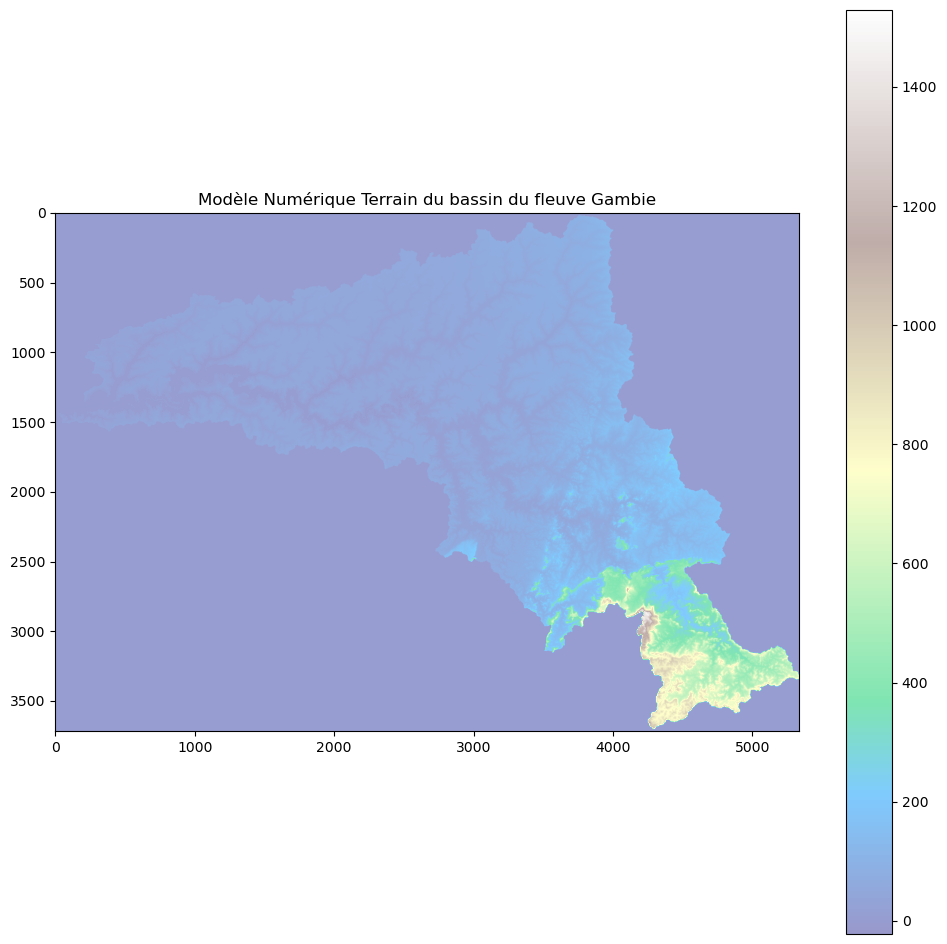

In [11]:
# charger le MNT
mnt = pcr.readmap('Data/PCRaster_files/mnt.map')
# Convertir mnt en tableau numpy
mnt_numpy = pcr_to_numpy(mnt, np.nan)
# Visualisation
visualization_raster(
    raster_numpy=mnt_numpy,
    cmap='terrain')

#### Génération de LDD (Local Drain Direction)
Le LDD est une composante fondamentale dans toute modélisation hydrologique. Il représente, pour chaque cellule du MNT(Modéle Numérique Terrain, la direction dans laquelle l'eau s'écoule vers une cellule voisine. Cette structure est indispensable pour simuler le ruissellement, l'accumulation ou les inondations.

In [12]:
# Fonction de calcul de direction
def calculate_flow_direction(dem_file):
    dem = pcr.readmap(dem_file)
    #dem_filled = pcr.lddcreatedem(dem, 1e31, 1e31, 1e31, 1e31)
    #pcr.report(dem_filled, 'Data/PCRaster_files/mnt_corrige.map')
    
    flow_direction = pcr.lddcreate(dem, 1e31, 1e31, 1e31, 1e31)
    pcr.report(flow_direction, 'Data/PCRaster_files/ldd.map')
    #return ldd

calculate_flow_direction('Data/PCRaster_files/mnt.map')

#### Délimition du fleuve Gambie dans le cadre de la modélisation des inondations:
Dans le cadre de ce projet, l'objectif principal de la délimitation du cours est d'identifier précisément le lit majeur du fleuve Gambie, en excluant les affluents secondaires. Cette délimitation est essentielle pour:
- Localiser les zones suceptibles de débordées.
- Simuler l'expension spatiale des inondations depuis le fleuve principal.
- Intégrer les stations de mesure (Kédougou et Mako) dans une analyse cohérente et réaliste

##### Méthode utlisée: ordre de strahler: 
Pour identifier le fleuve principale parmi l'ensemble des réseaux hydrographique, nous allons utilisé la technique basée sur **l'ordre de Strahler** qui permet de:
+ classer les rivières selon leur importance topologique dans un réseau hydrographique
+ Filtrer les affuents secondaires à l'aide d'un seuil élevé
+ Générer une carte du cours d'eau principal à partir d'un LDD (local Drainage Direction)

In [13]:
# Calculer l'ordre de Strahler et extraire le réseau pour chaque ordre
def stream_delineation(flow_direction_map): # Avec comme paramètre, le LDD
    
    orders = pcr.streamorder(flow_direction_map)
    pcr.report(orders, 'Data/Streams/strahler.map') # enregistrer sous forme de carte pcraster les ordres de Strahler
    """order_max = pcr.mapmaximum(orders)
    order_max_value = pcr.cellvalue(order_max, 1, 1)[0]
    for order in range(1, order_max_value+1):
        stream = pcr.ifthen(orders >= order, pcr.scalar(1))
        pcr.report(stream, f'Data/Streams/stream{str(order)}.map')"""
    return orders


In [14]:
# Charger le réseau de drainage générer à partir de la fonction calculate_flow_direction
ldd = pcr.readmap('Data/PCRaster_files/ldd.map')

##### validation 
1. Objectif
L'objectif est de valider si le réseau hydrographique extrait à partir des ordres de Stahler assure une connexion continue entre ls stations de Kédougou et Mako.
2. Méthode
* Filtrage de cours d'eau
Sélectionner uniquement les rivières ayant un ordre de Stahler supèrieur ou égal à un seuil donnée
* Affichage Graphique
Afficher en fond de carte les cours d'eau sélectionner puis placer les stations Kédougou et Mako sur la carte.
* Observation
Vérifier visuellement si les stations Kédougou et Mako tombent dans le masque.
3. Justification de la méthode
* La validation graphique permet d'observer directement la structure du résau hydrographique sans ambiguité
* Elle offre une onfirmation visuelle de la connectivité entre les deux stations, ce qui est plus fiable qu'une validation numérique

In [15]:

#définition d'une fonction de conversion des coordonnées géographiques en indice de pixel ou inversement
def geo_to_pixel(lon, lat, geotransform, inverse=False):
    """
    les coordonées GPS(longitude, latitude) des stations Hydrometrique doivent être convertis en coordonnées image(ligne, colonne).
    La conversion est nécessaire lorsqu'on travaille avec des rasters(comme un MNT, un LDD).
    - Station Kégoudou (-12.1833, 12.55)
    - Station Mako (-12.35, 12.8667)
    D'abord on va convertir les coordonnées géographiques en coordonnées projetées"""
    # 
    def gps_to_utm(lon, lat): #fonction pour convertir les coordonnées géographiques en coordonnées projetées
        transformer_wgs = Transformer.from_crs("EPSG:4326", "EPSG:32628", always_xy=True)
        
        x_proj, y_proj = transformer_wgs.transform(lon, lat)
        return [x_proj, y_proj]
        
    
    
    if inverse is True: 
        """si inverse est True, x et y sont en coordonnées géographiques, donc on les converties en coordonnées pixel
        après reprojection"""
        #print("Convertir Pixel à Géo")
        xcoord = geotransform[0] + x * geotransform[1]
        ycoord = geotransform[3] + y * geotransform[5]
    
    
    elif inverse is False:
            
        """si inverse est False, x et y sont en coordonnées pixel, donc on les converties en coordonnées projetées
        après reprojection"""
        x_utm, y_utm = gps_to_utm(lon, lat)
        #print("Convertir Géo a Pixel")
        xcoord = int((x_utm - geotransform[0]) / geotransform[1])
        ycoord = int((y_utm - geotransform[3]) / geotransform[5])
    else:
        print("le raster n'a pas de trasnformation")
    return xcoord, ycoord
#tester la fonction sur notre raster
# Choisir un GeoTransformation à partir de nos raster

#print(f"Station Kédougou en Coordonées image {kedougou}")
#print(f"Station Mako en Coordonées image {mako}")

In [16]:
def visualization_ldd_and_strahlers(ldd_numpy, strahler_calibrated_numpy, strahlers_complete_numpy,
                                    kedoudou_pixel_x, kedougou_pixel_y, mako_pixel_x, mako_pixel_y, threshold):
    
    fig, axes = plt.subplots(2, 2, figsize=(20, 15))
    
    # 1. Carte LDD
    axes[0, 0].imshow(ldd_numpy, cmap='viridis')
    axes[0, 0].set_title('Local Drain Direction(LDD)', fontsize=14)
    
    # 2. Carte Strahler avec ordre >= threshold en surbrillance
    axes[0, 1].imshow(strahler_calibrated_numpy, cmap='viridis')
    axes[0, 1].scatter(kedoudou_pixel_x, kedougou_pixel_y, color='blue', label='Kedougou', marker='x')
    axes[0, 1].scatter(mako_pixel_x, mako_pixel_y, color='red', label='Mako', marker='*')
    axes[0, 1].legend()
    axes[0, 1].set_title(f'Strahler >= {threshold}', fontsize=14)
    
    
    
    # 3. Carte de tous les ordres de Strahler
    axes[1, 0].imshow(strahlers_complete_numpy, cmap='viridis')
   
    axes[1, 0].set_title('Tous les ordres de Strahler', fontsize=14)
    
    
    # 4. Histogramme des ordres
    strahler_flat = strahlers_complete_numpy.flatten()
    axes[1, 1].hist(strahler_flat, bins=np.arange(1, np.max(strahlers_complete_numpy)+2)-0.5, edgecolor='black')
    axes[1, 1].set_yscale('log')
    axes[1, 1].set_title('Distribution des ordres de Strahler', fontsize=14)
    axes[1, 1].set_xlabel('Ordre')
    axes[1, 1].set_ylabel('Fréquence')
    axes[1, 1].grid(True)
    
    # Mise en forme
    plt.tight_layout()
    plt.show()
    plt.close()

In [17]:
# paramètres
ldd_numpy = pcr_to_numpy(ldd, np.nan) # convertir le LDD en tableau numpy
orders = stream_delineation(ldd) # Ordre de strahler, ordre maximum 11
orders_numpy = pcr_to_numpy(orders, np.nan)


In [21]:
threshold = 10 # doit être calibré 
strahler_threshold_order = orders >= threshold # Capturer les cours d'eau avec un ordre >= strahler_order_threshold
river = pcr.lddmask(ldd, strahler_threshold_order)
pcr.report(river, './Data/Streams/river.map')
river = pcr.defined(river)
river_numpy = pcr_to_numpy(river, np.nan)
geotransform = gdal.Open('Data/Aligned_rasters/mnt_utm.tif').GetGeoTransform()
kedougou_pixel_x, kedougou_pixel_y = geo_to_pixel(-12.1833, 12.55, geotransform) # coordonnées en pixel de la station Kédougou
mako_pixel_x, mako_pixel_y= geo_to_pixel(-12.35, 12.8667, geotransform) # coordonnées en pixel de la station de Mako

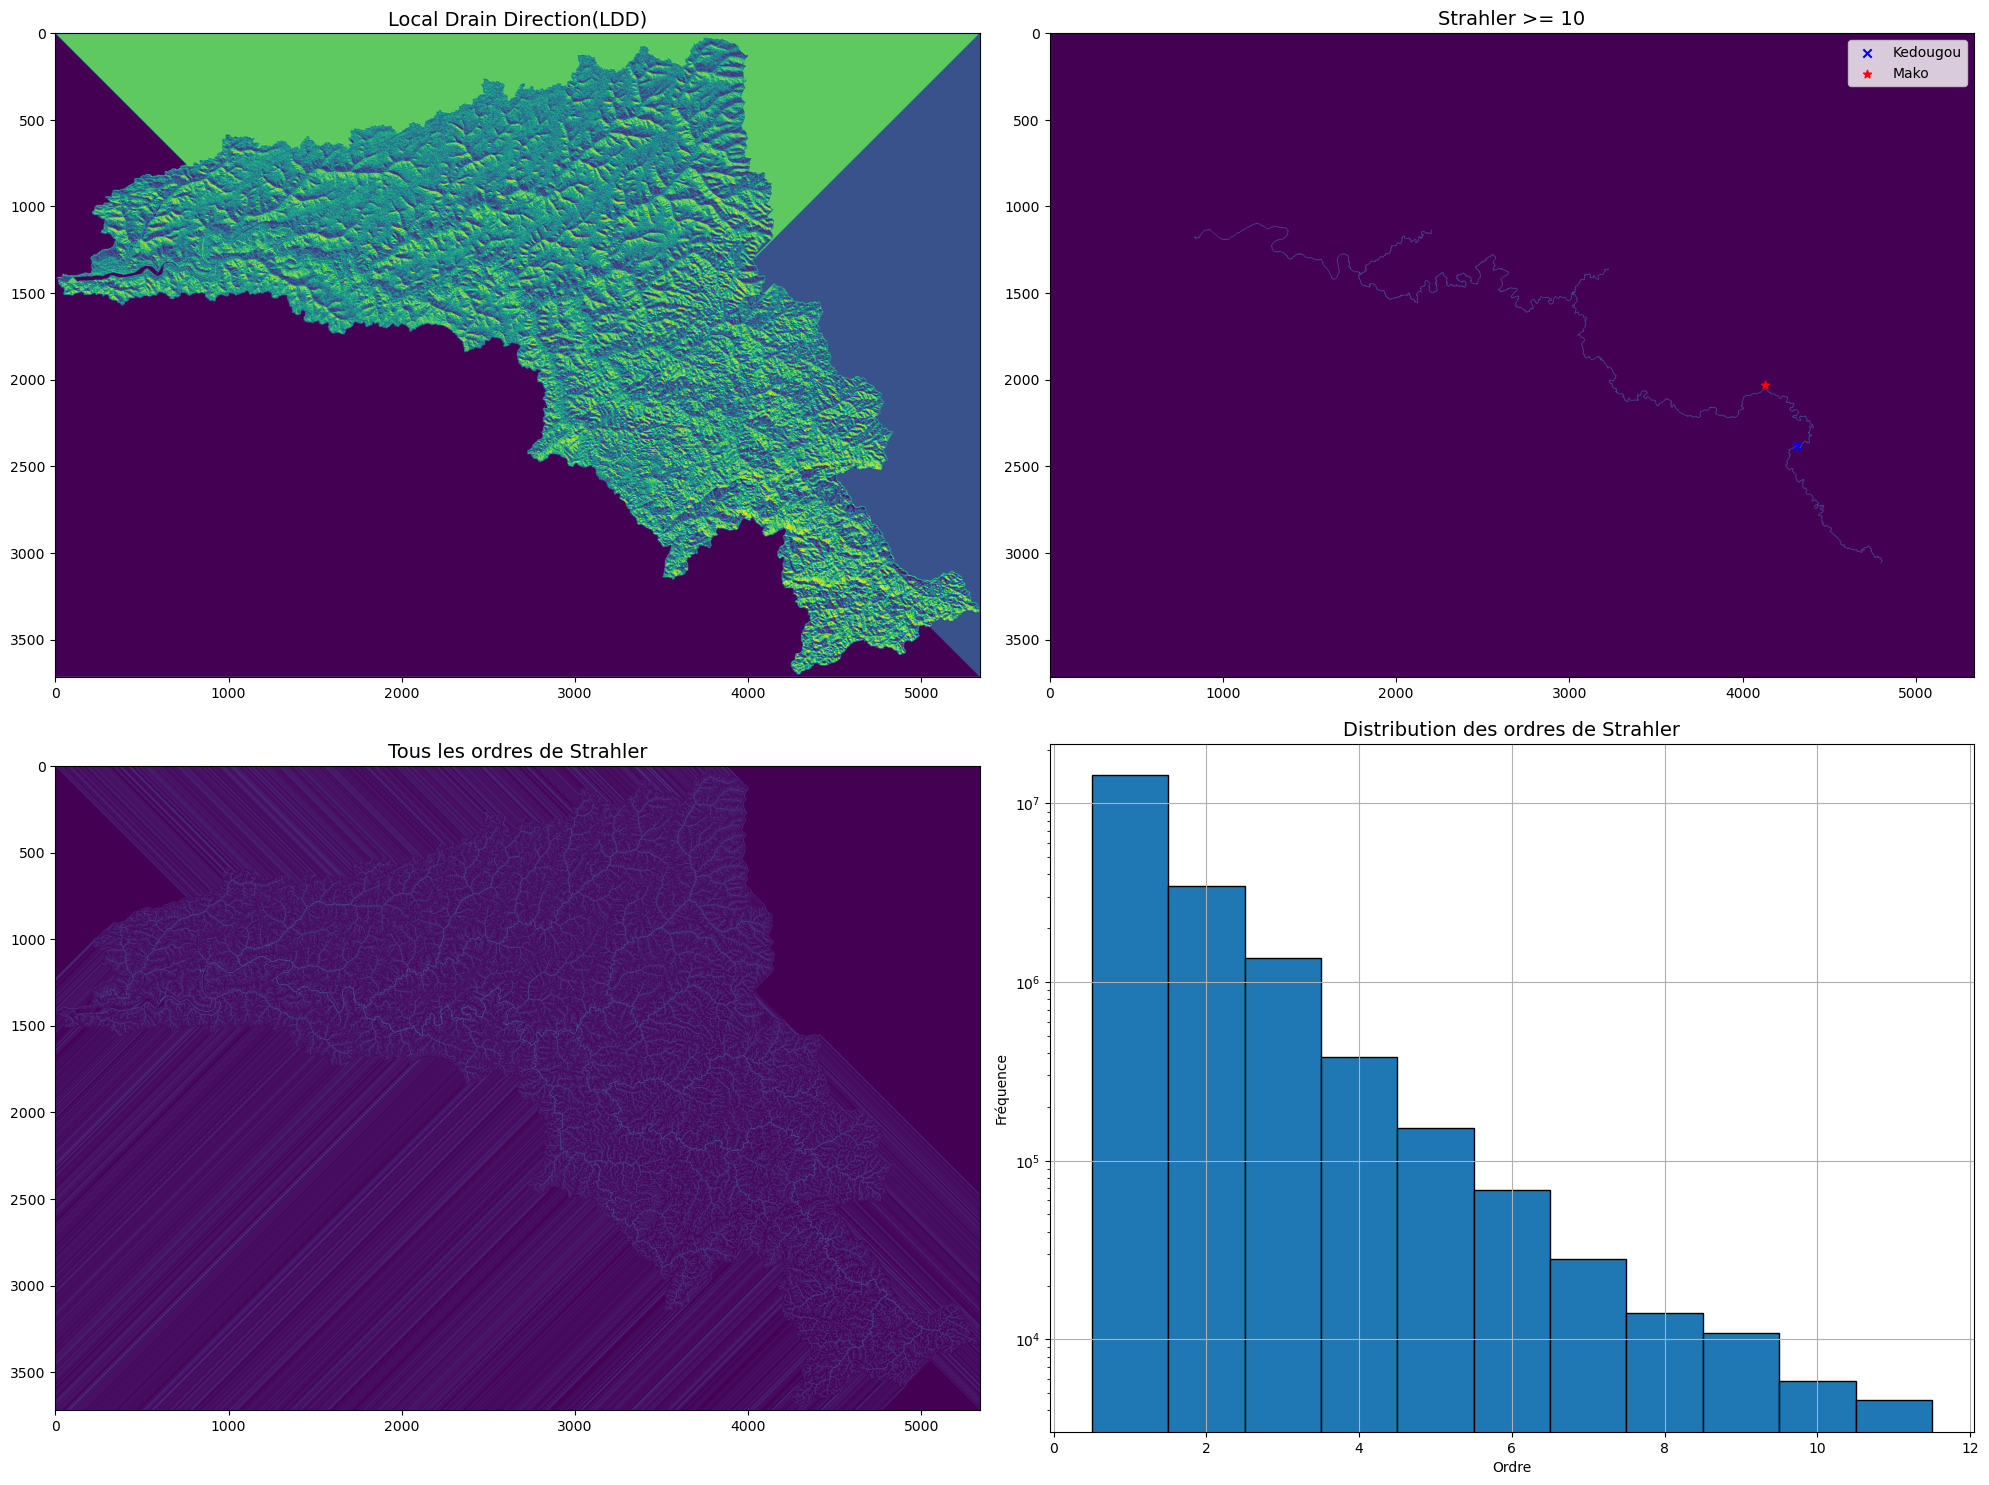

In [22]:
# Visualisation
visualization_ldd_and_strahlers(ldd_numpy=ldd_numpy, 
                                strahler_calibrated_numpy=river_numpy, 
                                strahlers_complete_numpy=orders_numpy, 
                                kedoudou_pixel_x=kedougou_pixel_x, 
                                kedougou_pixel_y=kedougou_pixel_y,
                                mako_pixel_x=mako_pixel_x, 
                                mako_pixel_y=mako_pixel_y,
                                threshold=threshold)

##### Commentaire
En utilisant l'approche graphique, les stations de Kédougou et de Mako ont été capturée par les segments d'ordre 10, l'ordre maximal étant 11. Cela indique que l'ordre 10 correspond au tronçon principal du fleuve Gambie entre les deux stations, tandis que l'ordre 11 est atteint plus en aval. Cet approche permet d'inclure non seulement les segments d'ordre 10, correspondant aux stations de Kédougou et Mako, mais également les portions de cours atteignant l'ordre maximal(11).

#### Définition de points de mesure au niveau des stations (Kédougou et Mako)
##### 1. Problème observé:
Lors de l'extraction de l'ordre de Strahler autour des coordonnées pixelisées des deux stations, nous avons obtenues des valeurs très faibles(ordre = 1), alors que, selon l'observation cartographique, ces stations devraient être situées sur des tronçons à l'ordre élevé(>=10).
##### 2. Hypothèse
Ce décalage est très propablement dû a un **rééchantillonnage spatial** notamment la *réduction de la résolution du MNT à 100 mètres.* Une telle résolution, bien que utile pour reduire le temps de calcul, introduit une perte de précision spatiale.
Ainsi les coordonnées exactes des stations peuvent tomber à proximité du fleuve sans concider exactement avec les cellules représentant son lit principal.
##### 3. Solution adaptée
Pour assurer la cohérence entre la réalité du terrain et notre modèle:
- Nous avons extrait la cellule d'ordre maximale la plus proche des stations
- Cette cellule est utilisée comme position corrigée de la station dans le modèle.
- Cela garantit que toutes les injections de débit(ou autre èvenement simulé) se fait dans le lit principal du fleuve, ce qui est essentiel pour représenter fidèlement les dynamiques hydrologiques.
4. ##### Justification
Ce repositionnement n'haltère pas la représentativité des stations, mais l'améliore dans le conteste du modèle rasterisé pour reconcilier précision spatiale et cohérence hydrologique, notamment lorsque l'on travaille avec des données en grille.


In [23]:
# Repositionnement de nos stations
def repositioning(x_pixel, y_pixel, strahler_order_numpy, repositioning_order):
    station_coords = (y_pixel, x_pixel)
    order = np.argwhere(strahler_order_numpy ==  repositioning_order)
    distances = np.linalg.norm(order - station_coords, axis=1)
    closest_index = np.argmin(distances)
    station_true = order[closest_index]
    """
    Gestion du décalage de l'index entre PCRaster et Numpy
    Lors de l'extraction de valeurs ou de l'analyse spatiale avec des rasters, il est crucial de prendre en compte
    le décalage d'indexation entre les bibliothèques PCRaster et Numpy.
    Le premier indexe les cellules à partir de (1, 1), le second en revanche utilise le point (0, 0) comme origine.
    """
    pixel_x = station_true[1] + 1
    pixel_y = station_true[0] + 1
    return pixel_x, pixel_y
    
kedougou_x, kedougou_y = repositioning(kedougou_pixel_x, kedougou_pixel_y, orders_numpy, threshold)
mako_x, mako_y = repositioning(mako_pixel_x, mako_pixel_y, orders_numpy, threshold)
kedougou_x, kedougou_y

(np.int64(4313), np.int64(2386))

In [24]:
# fonction une carte PCRaster pour les positions des station
def station_mask(station_x, station_y, template_map_path, output_path):
    """
    Créer une carte pcraster avec la station positionnée au bon endroit.
    Paramètre :
    - x_station: coordonnées x, en pixel, de la station
    - y_station: coordonnées y, en pixel, de la station
    - template_map_path: chemin vers un raster modèle
    """

    # 1. Lire les proprietés du modèle
    pcr.setclone(template_map_path)
    
    # 2. Charger les infos de géoréférencement
    clone = pcr.clone()
    nrow = clone.nrRows()
    ncol = pcr.clone().nrCols()
    
    # 3. Créer une matrice vide
    station_array = np.zeros((nrow, ncol), dtype=np.int8)
    
    if 0 <= station_x < ncol and 0 <= station_y < nrow:
        
        station_array[station_y - 1, station_x - 1] = 1
    else:
        raise ValueError('Station hors des limites du raster')
    # 4. Transformer en raster PCRaster
    station_raster = pcr.numpy2pcr(pcr.Boolean, station_array, 0)
    pcr.report(station_raster, output_path)
    print(f'Carte station créée: {output_path}')
    

In [25]:
# Définition des stations
template_map_path = './Data/PCRaster_files/landcover.map'
stations = {
    'kedougou':{
        'x': kedougou_x,
        'y': kedougou_y,
        'output_path': './Data/Stations/kedougou.map'
    },
    'mako':{
        'x': mako_x,
        'y': mako_y,
        'output_path': './Data/Stations/mako.map'
    }
}
for name, infos in stations.items():
     station_mask(
         station_x=infos['x'], 
         station_y=infos['y'], 
         template_map_path=template_map_path, 
         output_path=infos['output_path'])


Carte station créée: ./Data/Stations/kedougou.map
Carte station créée: ./Data/Stations/mako.map


#### Délimitation d'une zone de saturation autour de la station hydrométrique de kédougou
Créer une bande de bande de 30 km en amont une bande de 30 km en aval le long du cours d'eau centrée sur la station de Kédougou, afin de cibler l'analyse sur une zone d'influence directe.

In [27]:
def saturated(input_station, rayon_km):
    kedougou_station = pcr.readmap(input_station)
    river = pcr.readmap('./Data/Streams/river.map')
    kedougou_station = pcr.cover(kedougou_station, 0)
    rayon_m = rayon_km * 1000
    saturated_zone = pcr.spreadmaxzone(kedougou_station, 0, 1, rayon_m)  # buffer de 30 km autour de la station de Kédougou
    
    saturated_zone = pcr.ifthen(pcr.defined(river), saturated_zone)
    pcr.report(saturated_zone, './Data/Streams/saturated_zone.map')
input_station = './Data/Stations/kedoudou.map'
saturated(input_station, 30)

##### - Visualisation de la zone saturée

In [4]:
def view_zone(river_array, saturated_array):
    saturated_coords = np.argwhere(saturated_array==1)
    y, x = zip(*saturated_coords)
    plt.figure(figsize=(12, 12))
    plt.imshow(river_array, cmap='viridis')
    plt.scatter(x, y, color='blue', marker='.')
    plt.title('La zone saturée')
    plt.show()
    plt.close()


In [5]:
river = pcr.readmap('./Data/Streams/river.map')                        # Charger la rivière
river_numpy = pcr_to_numpy(pcr.defined(river), np.nan)                 # Convertir la carte PCRaster en tableau numpy
saturated_zone = pcr.readmap('./Data/Streams/saturated_zone.map')      # Charger la zone saturée
saturated_numpy = pcr_to_numpy(saturated_zone, np.nan)                 # Puis convertir en tableau numpy

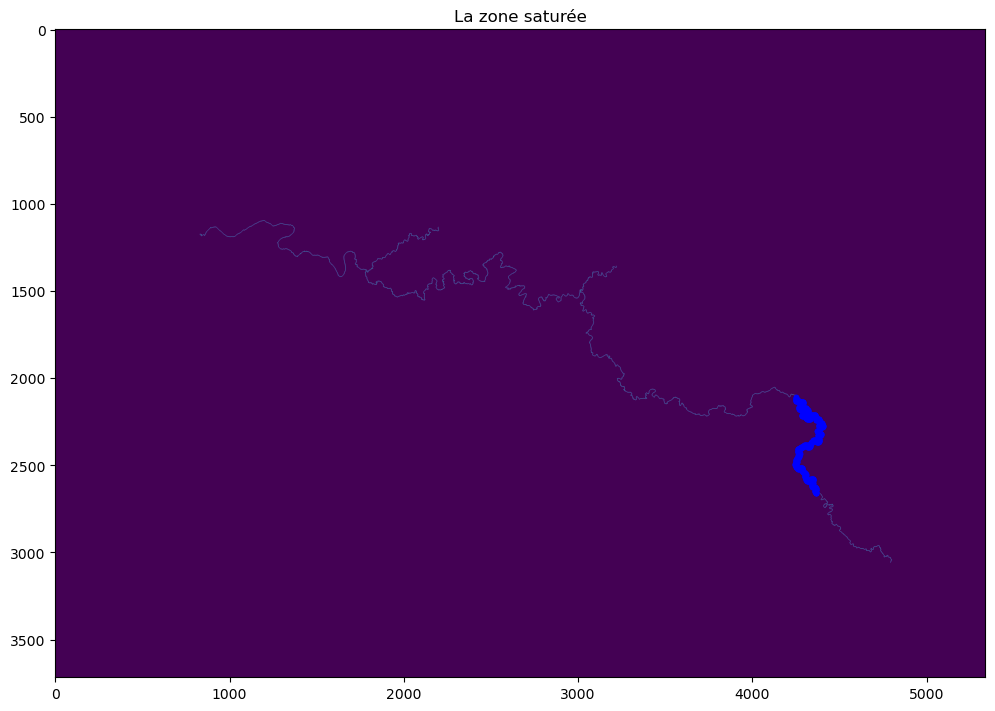

In [6]:
view_zone(river_numpy, saturated_numpy)

### Mise en place du `DynamicModel`
Après l'identification du cours d'eau principal à partir de l'ordre de Strahler (&#8805; 10). La prochaine étape consiste à simuler de manière temporelle le comportement hydrologique du bassin versant à l'aide du **modèle dynamique**. Ce type de modèle permet d'intégrer l'évolution des processus hydrologiques dans le temps, tels que l'écoulement, le ruissellement ou les inondations.

#### Préparation du modèle

In [7]:
class FloodModel(DynamicModel):
    def __init__(self, clone_map):
        DynamicModel.__init__(self)
        pcr.setclone(clone_map)
        
    def initial(self):

        
        
        # Chargement des données
        self.dem = pcr.readmap('./Data/PCRaster_files/mnt.map')               # Modèle Numérique Terrain
        
        self.kedougou_station = pcr.readmap('./Data/Stations/kedoudou.map')   # Station Kédougou
        self.mako_station = pcr.readmap('./Data/Stations/mako.map')           # Station Mako
        self.ldd = pcr.readmap('./Data/PCRaster_files/ldd.map')               # Réseau de drainage du fleuve
       
        self.river = pcr.readmap('./Data/Streams/river.map')                  # Lit pricipal du fleuve
        self.orders = pcr.readmap('./Data/Streams/strahler.map')               # Ordres de strahler
        self.saturated_zone = pcr.readmap('./Data/Streams/saturated_zone.map')
       
        
        
        # Capacité du lit 
        #slope = pcr.slope(self.dem)
        """ On suppose que le fleuve est sous une forme de trapège
        profondeur moyenne
        ordre de strahler o
        order_norm: order de Strahler normalisé
        a, b: coefficients empiriques
        ph: pente de talus
        largeur = a * order_norm
        profondeur = b * order_nom
        surface mouillée: A = (largeur + ph * profondeur)
        périmètre mouillé P = largeur + 2 * profondeur
        rayon hydraulique R = A/P
        coefficient manning n = 0.035, pour une rivière naturelle peu encombrée
        pente du lit S = dz / dx, Estimer la pente logitudinale du lit cellule par cellule
        capacité Q = (A * (R**(2/3)) * math.sqrt(S)) / n; unité m3/s
        """
        
        orders = pcr.scalar(self.orders)
        max_order = pcr.mapmaximum(orders)
        order_norm = orders / pcr.cellvalue(max_order, 1, 1)[0]
        
        river_dem = pcr.ifthen(pcr.defined(self.river), self.dem)                                   # Extraire l'altitude du lit
        downstream_dem = pcr.downstream(self.ldd, river_dem)                           # Récupérer l'altitude aval du lit
        dz =  river_dem - downstream_dem                                               # Différence d'altitude
        dx = 100                                                                       # Résolution
        s_min = 0.0009 * pcr.scalar(self.orders)                                       # Choisir une pente minimal pour éviter les blocages numériques
        S = pcr.max(dz / dx, s_min)                                                    # Calculer la pente entre une cellule et son aval
        ph = 5                                                                         # Représente une distance verticale h, on a une distance horizontale ph 
       
        
        a = 60
        b = 3
        river_width = a * order_norm
        river_depth = b * order_norm
        A = (river_width + ph) * river_depth 
        P = river_width + 2 * river_depth
        R = A / P
        n = 0.035                                                                       # Coéfficient de rugosité Rivière naturelle peu encombrée
        
        Q = (A * (R**(2/3)) * pcr.sqrt(S)) / n

        kedougou_capacity = pcr.ifthen(self.kedougou_station, 4 * Q)
                                                                 
        self.channel_capacity = pcr.ifthenelse(pcr.defined(self.river), 
                                          Q,
                                          pcr.scalar(0)                                             # Aucune capacité hors du lit
                                         )                                                # Capacité en m3/s

        #self.channel_capacity = pcr.cover(kedougou_capacity, self.channel_capacity)
         
        saturated_base_flow = pcr.ifthen(self.saturated_zone, pcr.scalar(0.5) * Q)
        river_base_flow = pcr.ifthen(pcr.defined(self.river), pcr.scalar(0.2) * Q)
    
        self.base_flow =  pcr.cover(saturated_base_flow, river_base_flow)                      # m3/s (débit permenant), Représente une fraction réaliste de la capacité
        self.current_height = 7.5                                                              # hauteur actuelle de l'eau à Kédougou (mètre)
        self.alert_height = 7                                                                  # Niveau d'alerte
        
         # Conversion du débit en hauteur d'eau en supposant 25m3/s = 10cm (courbe de tarage)
         # Calcul de l'excès de débit à évacuer
        self.overflow = (self.current_height - self.alert_height / self.current_height) * self.base_flow   # estimation de l'excès à évacuer
        self.flux_excess = pcr.ifthenelse(self.kedougou_station, self.overflow, pcr.scalar(0))
        self.flux_excess = pcr.cover(self.flux_excess, 0)
         
       
        # Capacité disponible pour l'excès
        self.available_capacity = self.channel_capacity - self.base_flow
        #self.available_capacity = pcr.max(0, self.available_capacity)              # eviter les valeurs négatives

        # Variables d'état 
        self.hour_to_second = 3600                                                  # heure en seconde
        #l'apport supplémentaire en eau provenant des affluents et cours d'eau secondaires dans la partie saturée
        self.state = pcr.ifthenelse(self.saturated_zone, pcr.scalar(0.4 * self.base_flow), 0)       
       
        # self.overland_flow = pcr.scalar(0)                                        # Pas de ruissellement à l'état initial
        

    def dynamic(self):

        timestep = self.currentTimeStep()                                 # Pas de temps
        # Convertir le débit en volume (m3) pour chaque pixel au pas de temps
        #flux_excess = pcr.ifthenelse(self.kedougou_station, self.overflow * math.exp(-0.5 * timestep), pcr.scalar(0))
        #flux_excess = pcr.scalar(self.kedougou_station) * self.overflow  * math.exp(-0.5 * self.currentTimeStep())
        
        

        # Calculer le flux à évacuer et les états des cellules du lit en tenant compte de la capacité disponible
        #ldd_mask = pcr.lddmask(self.ldd, self.river)    # Tenir uniquement le flux sur le lit du fleuve
        #ldd_mask = pcr.cover(ldd_mask, 0)
       
        flow = pcr.accucapacityflux(self.river, self.flux_excess + self.state, self.available_capacity )
        new_state = pcr.accucapacitystate(self.river, self.flux_excess + self.state, self.available_capacity)

        # Calcul du débordement latéral
        surplus = pcr.ifthenelse(pcr.boolean(new_state), pcr.max(0, new_state - self.channel_capacity), pcr.scalar(0))
        # Mise à jour du nouveau stock en retirant l'eau débordée
        self.state = new_state - surplus
        #downstream_total_flow = self.base_flow + evacuated
        self.flux_excess = self.flux_excess * math.exp(-0.5 * timestep) 
        
     
        
        pcr.report(flow, f"./Data/Resultats/flow_{str(timestep)}.map")
        pcr.report(new_state, f"./Data/Resultats/new_state_{str(timestep)}.map")
        pcr.report(new_state, f"./Data/Resultats/state_{str(timestep)}.map")
        pcr.report(surplus, f"./Data/Resultats/surplus_{str(timestep)}.map")
        #pcr.report(spillover, f"./Data/Resultats/spillover_{str(timestep)}.map")
        #pcr.report(self.overland_flow, f"./Data/Resultats/overland_flow_{str(timestep)}.map")
        #pcr.report(self.runoff_coeff, f"./Data/Resultats/runoff_coeff_{str(timestep)}.map")
        #pcr.report(friction, f"./Data/Resultats/friction_{str(timestep)}.map")
        #pcr.report(flux_excess, "./Data/Resultats/excess.map")
        #pcr.report(self.available_capacity, "./Data/Resultats/capacity.map")

#### Exécution du modèle

In [8]:
myModel = FloodModel('./Data/PCRaster_files/ldd.map')
dynModelFm = DynamicFramework(myModel, lastTimeStep=24, firstTimestep=1)
dynModelFm.run()

........................

0

#### Visualisation du résultat
Nous allons maintenant visualiser les pas de temps 1 et 24 afin d’observer la progression spatio-temporelle du débordement dans le modèle.
À la station de Kédougou, un volume d’eau décroissant est injecté pour simuler une stabilisation progressive du niveau. Parallèlement, une zone de 30 km de rayon centrée sur Kédougou est initialisée avec un state non nul afin de représenter l’eau provenant des affluents ou des cours d’eau d’ordre inférieur.

Cette configuration permet de simuler à la fois l’effet direct d’un apport local et l’effet diffus du ruissellement régional dans la dynamique des débordements.

In [9]:
def view_result(river_array, surplus_file, title):
    surplus = pcr.readmap(surplus_file)
    surplus = pcr.ifthen(surplus > 0, pcr.boolean(1))
    surplus_array = pcr_to_numpy(surplus, np.nan)
    indices = np.argwhere(surplus_array==1)
    if indices.size > 0:
        y, x = zip(*indices)
        plt.figure(figsize=(12, 12))
        plt.imshow(river_array, cmap='viridis')
        plt.scatter(x, y, color='blue', marker='.')
        plt.title(f'Les cellues débordées au pas de temps t={title}')
        plt.show()
        plt.close()

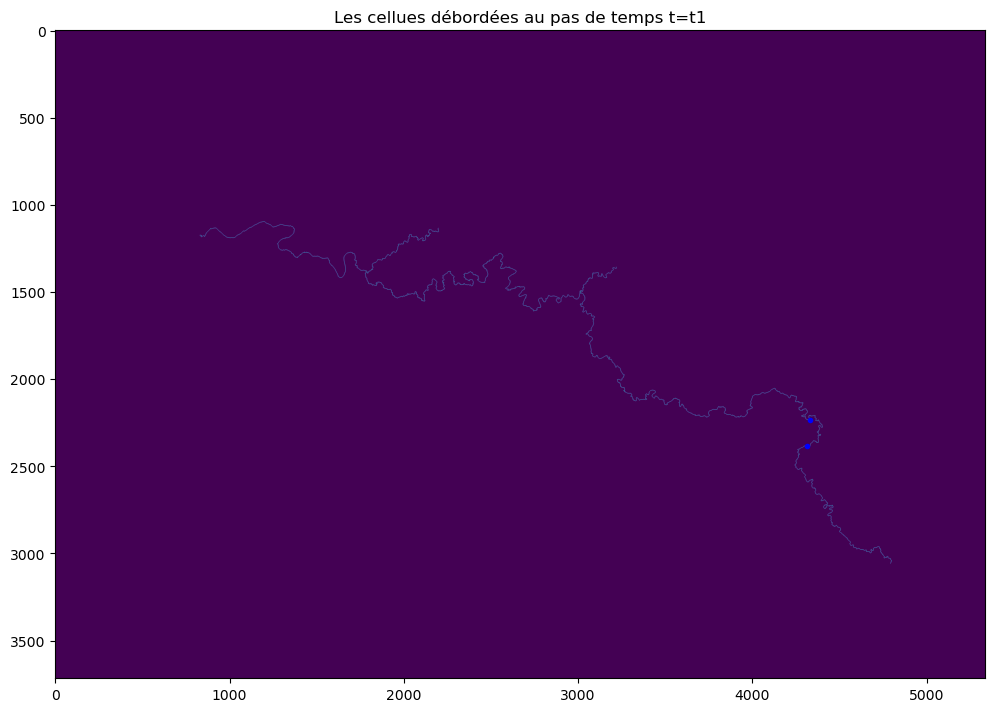

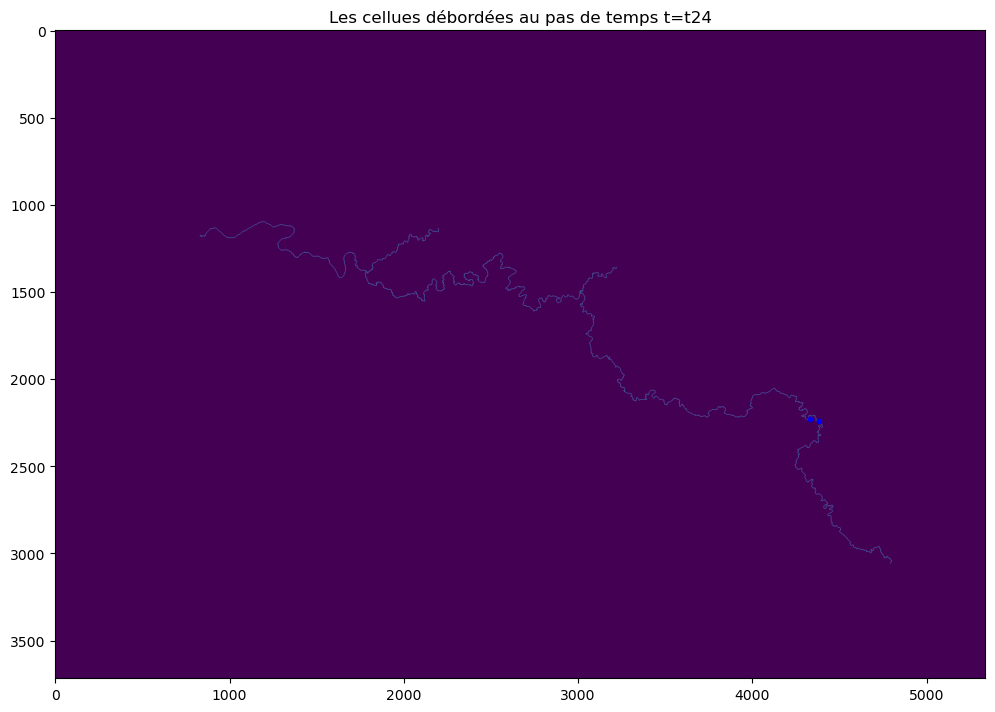

In [10]:
input_surplus = {'t1': "./Data/Resultats/surplus_1.map", 't24': "./Data/Resultats/surplus_24.map"}
for t, surplus_array in input_surplus.items():
    view_result(river_numpy, surplus_array, t)

#### Analyse de l’évolution du débordement (Pas de temps 1, 10 et 24)
Pas de temps t = 1 :
À ce stade initial, le débordement est observé dans la zone proche de Kédougou. Les premiers débordements apparaissent localement à proximité immédiate de la zone d'injection, où l'eau sature rapidement les cellules en raison de l'injection directe combinée à l’état initial élevé.
Le flux est encore peu dispersé, ce qui limite l'étendue de la zone affectée par le débordement.

Pas de temps t = 24 :
Au pas de temps 24, bien que la zone globale de débordement reste centrée autour de Kédougou, les cellules concernées ont changé.
Ce déplacement est dû à la dynamique de propagation du flux dans le réseau hydrographique : le ruissellement initial a migré vers l’aval, saturant progressivement d’autres cellules qui étaient jusque-là en état de charge sous critique.
Le débordement se manifeste donc dans d'autres points de la même région, ce qui révèle une évolution spatio-temporelle du phénomène, caractéristique d’un système fluvial réactif.